## Calculate the TSN intrinsic value

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
#load data
path_data = '../input/TSN_Q_exp.csv'
data = pd.read_csv(path_data, sep=';', parse_dates=[2])
# filter data
report = 'Q'
# end date years ago
years = 0
# start date 7 year earlier than end date
start_date = pd.Timestamp(datetime.date.today()) - pd.Timedelta(days=(7*365) + (years*365))
end_date = pd.Timestamp(datetime.date.today()) - pd.Timedelta(days=years*365)

data_filt = data.loc[(data['report'] == report) & (data['date'] > start_date) & (data['date'] < end_date), :]
data_filt.reset_index(drop=True, inplace=True)

In [3]:
data_filt.head()

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,short_debt,acc_pay,other_curr_liab,tot_curr_liab,tot_long_debt,other_liab,tot_equity,tot_liab,depr_amort,stock_b_comp
0,TSN,Q,2016-10-01,9156,8067,0,503,0,0,586,...,79,1511,1172,2762,6200.0,1242,9624,12749,179,20.25
1,TSN,Q,2017-01-01,9182,7699,0,501,0,0,982,...,66,1591,1315,2972,5901.0,1279,9567,12690,177,23.00
2,TSN,Q,2017-04-01,9083,8036,0,476,0,0,571,...,543,1466,1097,3106,5905.0,1280,9789,12807,179,23.00
3,TSN,Q,2017-07-01,9850,8648,0,505,0,0,697,...,1017,1608,1217,3865,9807.0,1265,10137,17926,187,23.00
4,TSN,Q,2017-10-01,10145,8794,0,670,0,0,681,...,906,1698,1424,4032,9297.0,1199,10559,17507,218,23.00


### Calculate EBITDA, EBIT, NOPAT, CAPEX etc on hisorical data

In [4]:
def calculate_missing_columns(df):
    df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
    df['ebit'] = df['ebitda'] - df['depr_amort']
    df['nopat'] = df['ebit'] - df['inc_tax_exp']
    df['other_curr_ass_lesscash'] = df['acc_rec'] + df['invent'] + df['other_curr_ass']
    df['tot_curr_liab_lessdebt'] = df['tot_curr_liab'] - df['short_debt']
    df['nwc'] = df['other_curr_ass_lesscash'] - df['tot_curr_liab_lessdebt']
    # capex calculation
    capex = []
    for index in range(len(df)):
        if index > 0:
            ppe_change = df['ppe_net'].iloc[index] - df['ppe_net'].iloc[index-1]
            depr_amort = df['depr_amort'].iloc[index]
            capex.append(ppe_change + depr_amort)
        else:
            capex.append(np.nan)
    df.loc[:, 'capex'] = capex

    return df

In [5]:
data_filt = calculate_missing_columns(data_filt)
data_filt.head()

/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_5956/3706664529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebitda'] = df['rev'] - df['cost_sale'] - df['sale_gen_adm'] - df['r_d'] - df['other_charg']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_5956/3706664529.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ebit'] = df['ebitda'] - df['depr_amort']
/var/folders/ds/_qwh_w111nvcxm803f83zkjh0000gn/T/ipykernel_5956/3706664529.py:4: SettingWithCopyWarning: 
A value is 

,ticker,report,date,rev,cost_sale,r_d,sale_gen_adm,inpairm,other_charg,op_income,...,tot_liab,depr_amort,stock_b_comp,ebitda,ebit,nopat,other_curr_ass_lesscash,tot_curr_liab_lessdebt,nwc,capex
0,TSN,Q,2016-10-01,9156,8067,0,503,0,0,586,...,12749,179,20.25,586,407,268,4539,2683,1856,NaN
1,TSN,Q,2017-01-01,9182,7699,0,501,0,0,982,...,12690,177,23.00,982,805,487,4435,2906,1529,213.0
2,TSN,Q,2017-04-01,9083,8036,0,476,0,0,571,...,12807,179,23.00,571,392,214,4774,2563,2211,256.0
3,TSN,Q,2017-07-01,9850,8648,0,505,0,0,697,...,17926,187,23.00,697,510,341,5196,2848,2348,449.0
4,TSN,Q,2017-10-01,10145,8794,0,670,0,0,681,...,17507,218,23.00,681,463,278,5133,3126,2007,241.0


### 2.1. Forecast Revenue

Before the ARIMA / SARIMA modling need to know p, d, q values (model parameters):
- p: Trend autoregression order.
- q: Trend moving average order.
- d: Trend difference order.

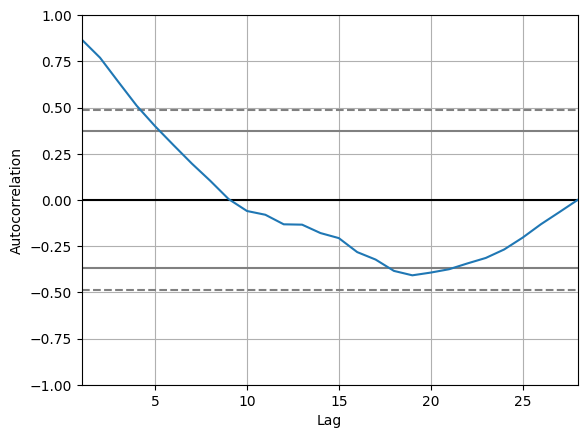

In [6]:
# Creating Autocorrelation plot - ACF
x = pd.plotting.autocorrelation_plot(data_filt['rev'])
x.plot()
plt.show()

The monotony of ACF is changed first time there is the p value. 

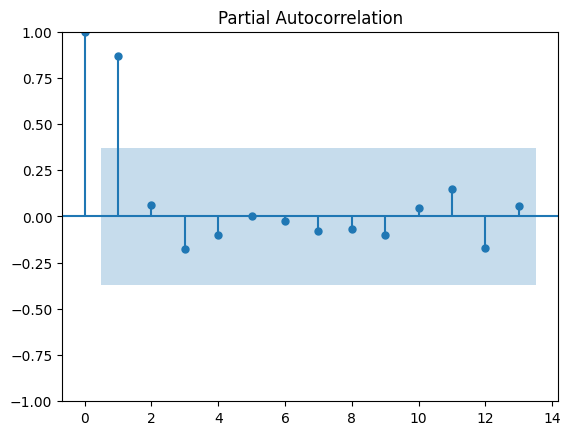

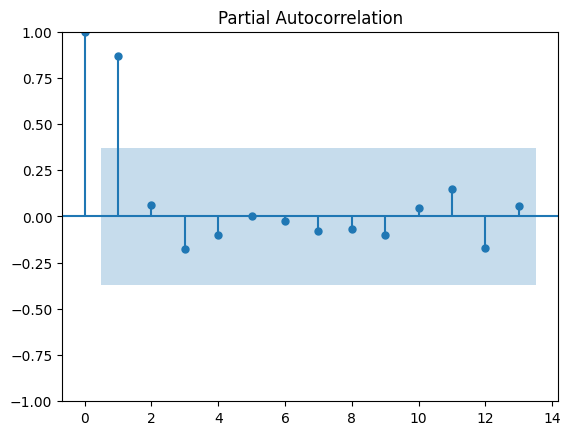

In [7]:
# Creating Partial Autocorrelation plot --> PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_filt['rev'], lags = 13)

Number of points, which are far away from the boundary is the q value.

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how a decide the q value. Hence the value of q is 2.

The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

I will find ARIMA hyperparameters (p, d, q) with gridsearch step-by-step

In [8]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    print(error)
    return error

In [9]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [10]:
# evaluate an ARIMA model for a given order (p,d,q) ---> You can tip p and estimate d, q based on previous plots
series = data_filt['rev']
# evaluate parameters
p_values = [2, 4, 6, 8, 10, 12]
d_values = [1]
q_values = [1, 2, 3]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

319308.9538501059
ARIMA(2, 1, 1) MSE=319308.954
280141.247133646
ARIMA(2, 1, 2) MSE=280141.247
408385.5703613299
ARIMA(2, 1, 3) MSE=408385.570
330589.7557919711
ARIMA(4, 1, 1) MSE=330589.756
411936.4789912712
ARIMA(4, 1, 2) MSE=411936.479
357923.3031949821
ARIMA(4, 1, 3) MSE=357923.303
436264.61409319396
ARIMA(6, 1, 1) MSE=436264.614
340127.58516257536
ARIMA(6, 1, 2) MSE=340127.585
385445.1128317635
ARIMA(8, 1, 1) MSE=385445.113
375421.89660459134
ARIMA(8, 1, 2) MSE=375421.897
1010658.1030409873
ARIMA(8, 1, 3) MSE=1010658.103
5054369661.442976
ARIMA(12, 1, 1) MSE=5054369661.443
2547913.6335770884
ARIMA(12, 1, 2) MSE=2547913.634
Best ARIMA(2, 1, 2) MSE=280141.247


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model.

The parameter "s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect. Here is hardcoded, works well with 12.

In [12]:
# float datatype is needed to SARIMAX model
data_filt['rev'] = data_filt['rev'].astype(float)

In [15]:
# use the model parameters of SARIMA
p, d, q = 2, 1, 1
model=sm.tsa.statespace.SARIMAX(data_filt['rev'].values,
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32585D+00    |proj g|=  1.78156D-01

At iterate    5    f=  4.27491D+00    |proj g|=  6.01124D-02

At iterate   10    f=  4.26260D+00    |proj g|=  1.98732D-02

At iterate   15    f=  4.25999D+00    |proj g|=  1.41898D-03

At iterate   20    f=  4.25983D+00    |proj g|=  9.23124D-04

At iterate   25    f=  4.25982D+00    |proj g|=  1.25332D-04

At iterate   30    f=  4.25982D+00    |proj g|=  2.51977D-03

At iterate   35    f=  4.25904D+00    |proj g|=  2.08105D-02

At iterate   40    f=  4.25220D+00    |proj g|=  3.05340D-02

At iterate   45    f=  4.24229D+00    |proj g|=  1.77891D-02

At iterate   50    f=  4.23894D+00    |proj g|=  9.91923D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [18]:
period = 20
# use SARIMAX model
prediction_revenue = model.predict(len(data_filt), len(data_filt)+period)
# df from results
prediction = pd.DataFrame(
    prediction_revenue,
    index=[i+1 for i in range(len(prediction_revenue))],
    columns=['rev']
)

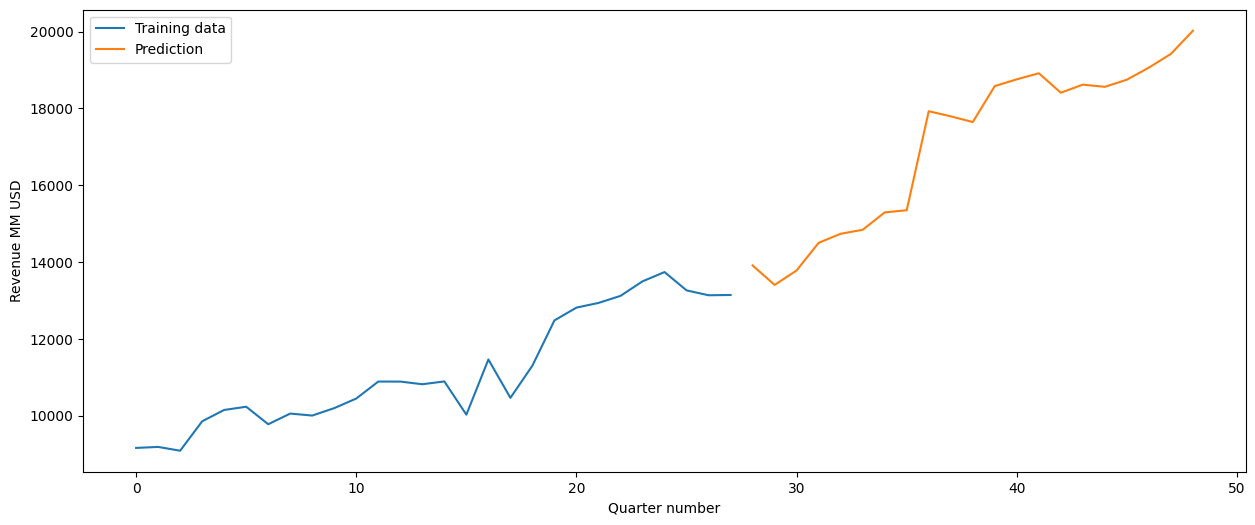

In [19]:
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(data_filt['rev'].index, data_filt['rev'].values, label='Training data')
ax1.plot(prediction.index+len(data_filt)-1, prediction['rev'], label='Prediction')

ax1.set_xlabel('Quarter number')
ax1.set_ylabel('Revenue MM USD')

plt.legend()
plt.show()

### 2.2. Calculate ratios

After the revenue prediction I calculate the expenses and use those to predict future CoS and EBITDA.